**Import Libraries**

In [1]:
import requests
import pandas as pd
import numpy as np
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import time
import json

**Create a list for ranking safety and property price**

In [2]:
borough_rank = [1,2,3,4,5]

**Import, filter and cleanup the datasets**

NYC Crime Dataset

In [3]:
safety_df = pd.read_csv('NYPD_Complaint_Data.csv')['BORO_NM'].value_counts().to_frame().reset_index()

safety_df.columns = ['Borough', 'Safety Score']
safety_df.iloc[:,1] = safety_df.iloc[:,1]/(safety_df.iloc[:,1].max())
safety_df['Safety Score'] = safety_df['Safety Score'].reset_index(drop=True) # normalize Safety Score for each boroughs.
safety_df.insert(2,'Safety Rank', borough_rank)
safety_df

,Borough,Safety Score,Safety Rank
0,BROOKLYN,1.000000,1
1,MANHATTAN,0.775386,2
2,BRONX,0.720667,3
3,QUEENS,0.671501,4
4,STATEN ISLAND,0.154422,5


NYC Property Sales dataset

In [4]:
property_df = pd.read_csv('nyc-rolling-sales.csv')[['BOROUGH', 'SALE PRICE']]

property_df = property_df[property_df['SALE PRICE']!=' -  ']
property_df['SALE PRICE'] = property_df['SALE PRICE'].astype('int64')
property_df = property_df[property_df['SALE PRICE']>=100]
property_df = property_df.groupby('BOROUGH').mean().astype('int64')['SALE PRICE'].sort_values(ascending=False).to_frame().reset_index()
property_df.iloc[:,1] = property_df.iloc[:,1]/(property_df.iloc[:,1].max())
property_df.insert(2, 'Property Price Rank', borough_rank)
property_df

,BOROUGH,SALE PRICE,Property Price Rank
0,Manhattan,1.000000,1
1,Brooklyn,0.387012,2
2,Bronx,0.243970,3
3,Queens,0.222888,4
4,Staten Island,0.164314,5


NYC neighborhoods geojson file Extraction

In [5]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']

In [6]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
...,...,...,...,...
301,Manhattan,Hudson Yards,40.756658,-74.000111
302,Queens,Hammels,40.587338,-73.805530
303,Queens,Bayswater,40.611322,-73.765968
304,Queens,Queensbridge,40.756091,-73.945631


Combine necessary columns

In [7]:
safety_score = []
safety_rank = []
for index, row in neighborhoods.iterrows():
    
    for i, r in safety_df.iterrows():
        if row['Borough'].upper() == r['Borough']:
            safety_score.append(r['Safety Score'])
            safety_rank.append(r['Safety Rank'])

neighborhoods.insert(1, 'Safety Score', safety_score)
neighborhoods.insert(2, 'Safety Rank', safety_rank)
neighborhoods

,Borough,Safety Score,Safety Rank,Neighborhood,Latitude,Longitude
0,Bronx,0.720667,3,Wakefield,40.894705,-73.847201
1,Bronx,0.720667,3,Co-op City,40.874294,-73.829939
2,Bronx,0.720667,3,Eastchester,40.887556,-73.827806
3,Bronx,0.720667,3,Fieldston,40.895437,-73.905643
4,Bronx,0.720667,3,Riverdale,40.890834,-73.912585
...,...,...,...,...,...,...
301,Manhattan,0.775386,2,Hudson Yards,40.756658,-74.000111
302,Queens,0.671501,4,Hammels,40.587338,-73.805530
303,Queens,0.671501,4,Bayswater,40.611322,-73.765968
304,Queens,0.671501,4,Queensbridge,40.756091,-73.945631


In [8]:
property_price = []
price_rank = []
for index, row in neighborhoods.iterrows():
    
    for i, r in property_df.iterrows():
        if row['Borough'] == r['BOROUGH']:
            property_price.append(r['SALE PRICE'])
            price_rank.append(r['Property Price Rank'])

neighborhoods.insert(3, 'Property Price', property_price)
neighborhoods.insert(4, 'Property Price Rank', price_rank)
neighborhoods

,Borough,Safety Score,Safety Rank,Property Price,Property Price Rank,Neighborhood,Latitude,Longitude
0,Bronx,0.720667,3,0.243970,3,Wakefield,40.894705,-73.847201
1,Bronx,0.720667,3,0.243970,3,Co-op City,40.874294,-73.829939
2,Bronx,0.720667,3,0.243970,3,Eastchester,40.887556,-73.827806
3,Bronx,0.720667,3,0.243970,3,Fieldston,40.895437,-73.905643
4,Bronx,0.720667,3,0.243970,3,Riverdale,40.890834,-73.912585
...,...,...,...,...,...,...,...,...
301,Manhattan,0.775386,2,1.000000,1,Hudson Yards,40.756658,-74.000111
302,Queens,0.671501,4,0.222888,4,Hammels,40.587338,-73.805530
303,Queens,0.671501,4,0.222888,4,Bayswater,40.611322,-73.765968
304,Queens,0.671501,4,0.222888,4,Queensbridge,40.756091,-73.945631


**Check for duplicated names in neighborhoods**

In [9]:
neighborhoods[neighborhoods.Neighborhood.duplicated()]

,Borough,Safety Score,Safety Rank,Property Price,Property Price Rank,Neighborhood,Latitude,Longitude
180,Queens,0.671501,4,0.222888,4,Murray Hill,40.764126,-73.812763
220,Staten Island,0.154422,5,0.164314,5,Sunnyside,40.612760,-74.097126
235,Staten Island,0.154422,5,0.164314,5,Bay Terrace,40.553988,-74.139166
244,Staten Island,0.154422,5,0.164314,5,Chelsea,40.594726,-74.189560


**Add borough names to neighborhood names to make it unique**

In [10]:
neighborhoods.Neighborhood = neighborhoods.Neighborhood + ' - ' + neighborhoods.Borough
neighborhoods

,Borough,Safety Score,Safety Rank,Property Price,Property Price Rank,Neighborhood,Latitude,Longitude
0,Bronx,0.720667,3,0.243970,3,Wakefield - Bronx,40.894705,-73.847201
1,Bronx,0.720667,3,0.243970,3,Co-op City - Bronx,40.874294,-73.829939
2,Bronx,0.720667,3,0.243970,3,Eastchester - Bronx,40.887556,-73.827806
3,Bronx,0.720667,3,0.243970,3,Fieldston - Bronx,40.895437,-73.905643
4,Bronx,0.720667,3,0.243970,3,Riverdale - Bronx,40.890834,-73.912585
...,...,...,...,...,...,...,...,...
301,Manhattan,0.775386,2,1.000000,1,Hudson Yards - Manhattan,40.756658,-74.000111
302,Queens,0.671501,4,0.222888,4,Hammels - Queens,40.587338,-73.805530
303,Queens,0.671501,4,0.222888,4,Bayswater - Queens,40.611322,-73.765968
304,Queens,0.671501,4,0.222888,4,Queensbridge - Queens,40.756091,-73.945631


**Foursquare API Credentials**

In [11]:
CLIENT_ID = 'client-id'
CLIENT_SECRET = 'client-secret'
VERSION = '20180604'
LIMIT = 100
radius = 500

**Pull venues data from Foursquare and combine it into the dataframe**

In [12]:
start_time = time.time()

venues_list=[]
for i, row in neighborhoods.iterrows():

    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'
       .format(CLIENT_ID, CLIENT_SECRET, row['Latitude'], row['Longitude'], VERSION, radius, LIMIT))
    
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
    except:
        print('\nError, retry after 5 seconds.\n{}. {}\n'.format(i, row['Neighborhood']))
        time.sleep(5)
        results = requests.get(url).json()['response']['groups'][0]['items']
    
    venues_list.append([(row['Neighborhood'],row['Safety Score'], row['Safety Rank'], row['Property Price'], row['Property Price Rank'], row['Borough'], row['Latitude'], row['Longitude'],
                         v['venue']['name'], 
                         v['venue']['location']['lat'], 
                         v['venue']['location']['lng'],  
                         v['venue']['categories'][0]['name']) for v in results])
    
    for n in np.arange(0.1,1.1,0.1):
        if (i+1)==int(306*n):
            print('{} %'.format(int(n*100)))

elapsed = time.time() - start_time
print('\nTotal Time Taken: {} hour/s {} minutes\n'.format(int(elapsed/3600), round(((elapsed/3600)-int(elapsed/3600))*60) ))

NYC_venues = pd.DataFrame([item for venue in venues_list for item in venue])

NYC_venues.columns = ['Neighborhoods',
                      'Safety Score',
                      'Safety Rank',
                      'Property Price',
                      'Property Price Rank',
                      'Borough',
                      'Latitude',
                      'Longitude',
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category']
print(NYC_venues.shape)
NYC_venues.head()

10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %

Total Time Taken: 0 hour/s 3 minutes

(9826, 12)


,Neighborhoods,Safety Score,Safety Rank,Property Price,Property Price Rank,Borough,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield - Bronx,0.720667,3,0.24397,3,Bronx,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield - Bronx,0.720667,3,0.24397,3,Bronx,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
2,Wakefield - Bronx,0.720667,3,0.24397,3,Bronx,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,Wakefield - Bronx,0.720667,3,0.24397,3,Bronx,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
4,Wakefield - Bronx,0.720667,3,0.24397,3,Bronx,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


**Perform one hot coding on the venues**

In [13]:
NYC_ohc = pd.concat([NYC_venues[['Neighborhoods', 'Safety Score', 'Safety Rank', 'Property Price', 'Property Price Rank']], pd.get_dummies(NYC_venues['Venue Category'])], axis=1)
NYC_ohc.head()

,Neighborhoods,Safety Score,Safety Rank,Property Price,Property Price Rank,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Wakefield - Bronx,0.720667,3,0.24397,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Wakefield - Bronx,0.720667,3,0.24397,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Wakefield - Bronx,0.720667,3,0.24397,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Wakefield - Bronx,0.720667,3,0.24397,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Wakefield - Bronx,0.720667,3,0.24397,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Group the dataframe by `Neighborhood`, get the percentage of venue categories' popularity**

In [14]:
NYC_grouped = NYC_ohc.groupby('Neighborhoods').mean().reset_index()
NYC_grouped.head()

,Neighborhoods,Safety Score,Safety Rank,Property Price,Property Price Rank,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Allerton - Bronx,0.720667,3,0.243970,3,0.0,0.0,0.0,0.0,0.031250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale - Staten Island,0.154422,5,0.164314,5,0.0,0.0,0.0,0.0,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arden Heights - Staten Island,0.154422,5,0.164314,5,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arlington - Staten Island,0.154422,5,0.164314,5,0.0,0.0,0.0,0.0,0.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arrochar - Staten Island,0.154422,5,0.164314,5,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Sort the venue categories according to their popularity, create a new dataframe for top 10 most commonly visited venues**

In [15]:
top_10 = pd.DataFrame()

col_label = ['Neighborhoods', 'Safety Score', 'Safety Rank', 'Property Price', 'Property Price Rank']
for i in np.arange(1,11,1):
    col_label.append('No.{} Most visited Venue'.format(i))

for i, row in NYC_grouped.iterrows():
    row_data = pd.Series(list(NYC_grouped.iloc[i,[0,1,2,3,4]]) + list(NYC_grouped.iloc[i][5:].sort_values(ascending=False).head(10).index))
    top_10 = top_10.append(row_data, ignore_index=True)

top_10.columns = col_label
top_10

,Neighborhoods,Safety Score,Safety Rank,Property Price,Property Price Rank,No.1 Most visited Venue,No.2 Most visited Venue,No.3 Most visited Venue,No.4 Most visited Venue,No.5 Most visited Venue,No.6 Most visited Venue,No.7 Most visited Venue,No.8 Most visited Venue,No.9 Most visited Venue,No.10 Most visited Venue
0,Allerton - Bronx,0.720667,3.0,0.243970,3.0,Pizza Place,Deli / Bodega,Chinese Restaurant,Supermarket,Fast Food Restaurant,Bakery,Check Cashing Service,Mexican Restaurant,Grocery Store,Gas Station
1,Annadale - Staten Island,0.154422,5.0,0.164314,5.0,American Restaurant,Sports Bar,Deli / Bodega,Pizza Place,Diner,Pharmacy,Restaurant,Train Station,Cosmetics Shop,Pub
2,Arden Heights - Staten Island,0.154422,5.0,0.164314,5.0,Pharmacy,Coffee Shop,Pizza Place,Bus Stop,Field,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory
3,Arlington - Staten Island,0.154422,5.0,0.164314,5.0,Deli / Bodega,American Restaurant,Boat or Ferry,Bus Stop,Grocery Store,Yoga Studio,Fish & Chips Shop,Exhibit,Factory,Falafel Restaurant
4,Arrochar - Staten Island,0.154422,5.0,0.164314,5.0,Bus Stop,Italian Restaurant,Deli / Bodega,Pizza Place,Athletics & Sports,Middle Eastern Restaurant,Food Truck,Bagel Shop,Outdoors & Recreation,Sandwich Place
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,Woodhaven - Queens,0.671501,4.0,0.222888,4.0,Deli / Bodega,Park,Bank,Pharmacy,Nail Salon,Dive Bar,Metro Station,Thai Restaurant,Bagel Shop,Sandwich Place
300,Woodlawn - Bronx,0.720667,3.0,0.243970,3.0,Deli / Bodega,Pizza Place,Playground,Pub,Grocery Store,Food Truck,Bakery,Liquor Store,Trail,Donut Shop
301,Woodrow - Staten Island,0.154422,5.0,0.164314,5.0,Pharmacy,Mexican Restaurant,Cosmetics Shop,Bakery,Pizza Place,Bank,Donut Shop,Coffee Shop,Liquor Store,Grocery Store
302,Woodside - Queens,0.671501,4.0,0.222888,4.0,Grocery Store,Thai Restaurant,Latin American Restaurant,Bakery,Filipino Restaurant,Donut Shop,Pub,Pizza Place,Bar,American Restaurant


**Using K-Means Clustering to cluster the neighborhoods**  
1st, we need to find out the **best k** using **`SSE`**

In [16]:
start_time = time.time()

feat = NYC_grouped.drop(['Neighborhoods', 'Safety Rank', 'Property Price Rank'] , axis=1)

sse_list = []
for k in np.arange(1,21):
    kmeans = KMeans(n_clusters=k , n_init=100).fit(feat)
    
    sse_list.append(kmeans.inertia_)

elapsed = time.time() - start_time
print('Total Time Taken: {} minute/s  {} seconds\n'.format(int(elapsed/60), round(elapsed - (int(elapsed/60)*60)) ) )

Total Time Taken: 0 minute/s  19 seconds



Visualize the SSE

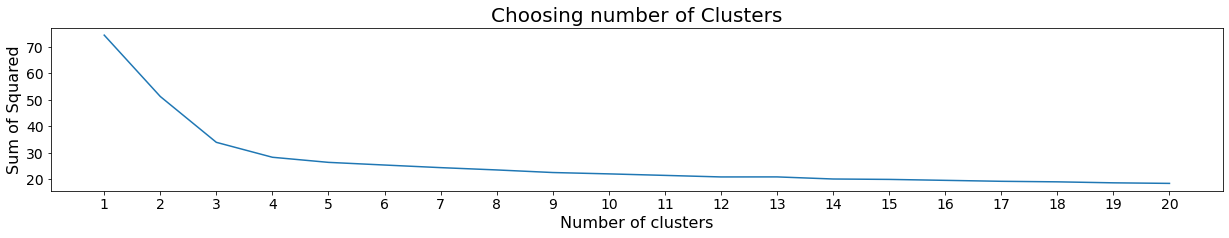

In [17]:
plt.figure(figsize=(21,3))
plt.plot(np.arange(1,21), sse_list)
plt.xticks(np.arange(1,21), size=14)
plt.yticks(size=14)
plt.title('Choosing number of Clusters', size=20)
plt.ylabel('Sum of Squared', size=16)
plt.xlabel('Number of clusters', size=16)
plt.show()

It seems that **3** clusters is a good number of clusters

**Initiate K-Means with `3` clusters and train the model, also create a copy of top 10 dataframe as clustered**

In [18]:
kmeans = KMeans(n_clusters=3, n_init=100).fit(feat)
top_10_clustered = top_10.copy()

**Remove non-retrievable locations from original dataframe and merge with clustered top 10 venues dataframe** (There are 2 neighborhoods that cannot be located using Foursquare API, it returns None)

In [19]:
hood_list = []
lat_list = []
lng_list =[]

for hood in top_10_clustered['Neighborhoods'].values:
    for i, row in neighborhoods.iterrows():
        if hood==row['Neighborhood']:
            hood_list.append(row['Neighborhood'])
            lat_list.append(row['Latitude'])
            lng_list.append(row['Longitude'])

updated_hoods = pd.DataFrame([hood_list, kmeans.labels_, lat_list, lng_list]).T
updated_hoods.columns = ['Neighborhoods', 'Cluster Label', 'Latitude', 'Longitude']
top_10_clustered = updated_hoods.join(top_10_clustered.set_index('Neighborhoods'), on='Neighborhoods')
top_10_clustered

,Neighborhoods,Cluster Label,Latitude,Longitude,Safety Score,Safety Rank,Property Price,Property Price Rank,No.1 Most visited Venue,No.2 Most visited Venue,No.3 Most visited Venue,No.4 Most visited Venue,No.5 Most visited Venue,No.6 Most visited Venue,No.7 Most visited Venue,No.8 Most visited Venue,No.9 Most visited Venue,No.10 Most visited Venue
0,Allerton - Bronx,0,40.8658,-73.8593,0.720667,3.0,0.243970,3.0,Pizza Place,Deli / Bodega,Chinese Restaurant,Supermarket,Fast Food Restaurant,Bakery,Check Cashing Service,Mexican Restaurant,Grocery Store,Gas Station
1,Annadale - Staten Island,2,40.5381,-74.1785,0.154422,5.0,0.164314,5.0,American Restaurant,Sports Bar,Deli / Bodega,Pizza Place,Diner,Pharmacy,Restaurant,Train Station,Cosmetics Shop,Pub
2,Arden Heights - Staten Island,2,40.5493,-74.1859,0.154422,5.0,0.164314,5.0,Pharmacy,Coffee Shop,Pizza Place,Bus Stop,Field,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory
3,Arlington - Staten Island,2,40.6353,-74.1651,0.154422,5.0,0.164314,5.0,Deli / Bodega,American Restaurant,Boat or Ferry,Bus Stop,Grocery Store,Yoga Studio,Fish & Chips Shop,Exhibit,Factory,Falafel Restaurant
4,Arrochar - Staten Island,2,40.5963,-74.0671,0.154422,5.0,0.164314,5.0,Bus Stop,Italian Restaurant,Deli / Bodega,Pizza Place,Athletics & Sports,Middle Eastern Restaurant,Food Truck,Bagel Shop,Outdoors & Recreation,Sandwich Place
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,Woodhaven - Queens,0,40.6899,-73.8581,0.671501,4.0,0.222888,4.0,Deli / Bodega,Park,Bank,Pharmacy,Nail Salon,Dive Bar,Metro Station,Thai Restaurant,Bagel Shop,Sandwich Place
300,Woodlawn - Bronx,0,40.8983,-73.8673,0.720667,3.0,0.243970,3.0,Deli / Bodega,Pizza Place,Playground,Pub,Grocery Store,Food Truck,Bakery,Liquor Store,Trail,Donut Shop
301,Woodrow - Staten Island,2,40.542,-74.2052,0.154422,5.0,0.164314,5.0,Pharmacy,Mexican Restaurant,Cosmetics Shop,Bakery,Pizza Place,Bank,Donut Shop,Coffee Shop,Liquor Store,Grocery Store
302,Woodside - Queens,0,40.7463,-73.9018,0.671501,4.0,0.222888,4.0,Grocery Store,Thai Restaurant,Latin American Restaurant,Bakery,Filipino Restaurant,Donut Shop,Pub,Pizza Place,Bar,American Restaurant


**Get coordinated of New York City and create the map with its coordinates**

In [20]:
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode('New York City, New York')
latitude = location.latitude
longitude = location.longitude

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

In [21]:
colors = ['red', 'blue', 'green']
for lat, lng, hood, label in zip(top_10_clustered['Latitude'], top_10_clustered['Longitude'], top_10_clustered['Neighborhoods'], top_10_clustered['Cluster Label']):
    
    Cluster_label = folium.Popup(str(hood) + ' Cluster: ' + str(label), parse_html=True)
    
    folium.CircleMarker([lat, lng],
                        radius=5,
                        popup=Cluster_label,
                        color=colors[label],
                        fill=True,
                        fill_color=colors[label],
                        fill_opacity=0.7
                       ).add_to(map_clusters)
map_clusters

Based on visualization on NYC map, the 3 clusters are:  
1. Around Manhattan Area,
2. Around Bronx, Queens and Brooklyn Area,
3. Around Staten Island Areas.

**Take a look at the number of neighborhoods in each cluster**

In [22]:
pd.set_option('display.max_rows', None)
top_10_clustered['Cluster Label'].value_counts(sort=False)

0    203
1     40
2     61
Name: Cluster Label, dtype: int64

**Cluster 1**

In [23]:
top_10_clustered.loc[top_10_clustered['Cluster Label'] == 0].reset_index(drop=True)['No.1 Most visited Venue'].value_counts().head(15)

Pizza Place             21
Deli / Bodega           15
Chinese Restaurant      13
Bar                     13
Italian Restaurant       9
Pharmacy                 9
Caribbean Restaurant     8
Donut Shop               8
Bus Station              7
Bank                     7
Beach                    6
Park                     6
Fried Chicken Joint      5
Coffee Shop              5
Bakery                   4
Name: No.1 Most visited Venue, dtype: int64

In [24]:
top_10_clustered.loc[top_10_clustered['Cluster Label'] == 0].iloc[:, [0, 4, 5, 6, 7]].reset_index(drop=True).head(15)

,Neighborhoods,Safety Score,Safety Rank,Property Price,Property Price Rank
0,Allerton - Bronx,0.720667,3.0,0.243970,3.0
1,Arverne - Queens,0.671501,4.0,0.222888,4.0
2,Astoria - Queens,0.671501,4.0,0.222888,4.0
3,Astoria Heights - Queens,0.671501,4.0,0.222888,4.0
4,Auburndale - Queens,0.671501,4.0,0.222888,4.0
5,Bath Beach - Brooklyn,1.000000,1.0,0.387012,2.0
6,Bay Ridge - Brooklyn,1.000000,1.0,0.387012,2.0
7,Bay Terrace - Queens,0.671501,4.0,0.222888,4.0
8,Baychester - Bronx,0.720667,3.0,0.243970,3.0
9,Bayside - Queens,0.671501,4.0,0.222888,4.0


people in cluster 1 loves pizza, Deli/Bodega and bars are often visited, there might have high numbers of Chinese communities, also might have moderate numbers of Italian and Caribbean communities.

Properties are moderate in price, higher crime rates

**Cluster 2**

In [25]:
top_10_clustered.loc[top_10_clustered['Cluster Label'] == 1, top_10_clustered.columns[[1] + list(range(5, top_10_clustered.shape[1]))]].reset_index(drop=True)[
'No.1 Most visited Venue'].value_counts().head(15)

Italian Restaurant      10
Coffee Shop              4
Café                     4
Park                     4
Mexican Restaurant       2
Pizza Place              2
Sandwich Place           2
Chinese Restaurant       2
Spa                      2
Theater                  1
Yoga Studio              1
Wine Bar                 1
Korean Restaurant        1
Art Gallery              1
Gym / Fitness Center     1
Name: No.1 Most visited Venue, dtype: int64

In [26]:
top_10_clustered.loc[top_10_clustered['Cluster Label'] == 1].iloc[:, [0, 4, 5, 6, 7]].reset_index(drop=True).head(15)

,Neighborhoods,Safety Score,Safety Rank,Property Price,Property Price Rank
0,Battery Park City - Manhattan,0.775386,2.0,1.0,1.0
1,Carnegie Hill - Manhattan,0.775386,2.0,1.0,1.0
2,Central Harlem - Manhattan,0.775386,2.0,1.0,1.0
3,Chelsea - Manhattan,0.775386,2.0,1.0,1.0
4,Chinatown - Manhattan,0.775386,2.0,1.0,1.0
5,Civic Center - Manhattan,0.775386,2.0,1.0,1.0
6,Clinton - Manhattan,0.775386,2.0,1.0,1.0
7,East Harlem - Manhattan,0.775386,2.0,1.0,1.0
8,East Village - Manhattan,0.775386,2.0,1.0,1.0
9,Financial District - Manhattan,0.775386,2.0,1.0,1.0


people in Cluster 2 loves coffee, there might be high numbers of Italian Communities, there might also be small numbers of Mexican, Chinese and Korean communities.

Properties are most expensive here, also higher crime rate

**Cluster 3**

In [27]:
top_10_clustered.loc[top_10_clustered['Cluster Label'] == 2, top_10_clustered.columns[[1] + list(range(5, top_10_clustered.shape[1]))]].reset_index(drop=True)[
'No.1 Most visited Venue'].value_counts().head(15)

Italian Restaurant        12
Bus Stop                   8
Deli / Bodega              4
Pizza Place                3
Mexican Restaurant         3
Chinese Restaurant         3
Pharmacy                   2
Bank                       2
American Restaurant        1
Rental Car Location        1
Pier                       1
Thrift / Vintage Store     1
Bar                        1
Bagel Shop                 1
Sushi Restaurant           1
Name: No.1 Most visited Venue, dtype: int64

In [28]:
top_10_clustered.loc[top_10_clustered['Cluster Label'] == 2].iloc[:, [0, 4, 5, 6, 7]].reset_index(drop=True).head(15)

,Neighborhoods,Safety Score,Safety Rank,Property Price,Property Price Rank
0,Annadale - Staten Island,0.154422,5.0,0.164314,5.0
1,Arden Heights - Staten Island,0.154422,5.0,0.164314,5.0
2,Arlington - Staten Island,0.154422,5.0,0.164314,5.0
3,Arrochar - Staten Island,0.154422,5.0,0.164314,5.0
4,Bay Terrace - Staten Island,0.154422,5.0,0.164314,5.0
5,Bloomfield - Staten Island,0.154422,5.0,0.164314,5.0
6,Bulls Head - Staten Island,0.154422,5.0,0.164314,5.0
7,Butler Manor - Staten Island,0.154422,5.0,0.164314,5.0
8,Castleton Corners - Staten Island,0.154422,5.0,0.164314,5.0
9,Charleston - Staten Island,0.154422,5.0,0.164314,5.0


Cluster 3 might have high numbers of Italian communities, people here like to visit cafes , also might have a small number of Mexican and Chinese Communities. 

Propertiest least expensive here, crime rate is lowest